# Single cell analysis of public NSCLC dataset (Xenium 5K)

In [1]:
library(Seurat)
library(Matrix)
library(ggplot2)
library(tidyverse)
library(harmony)
library(patchwork)

# Function for setting the size of figures in the notebook
figsize <- function(width, height) {
    options(repr.plot.width = width, repr.plot.height = height)
}

Warning message:
“package ‘Seurat’ was built under R version 4.0.5”
Warning message:
“replacing previous import ‘spatstat.utils::RelevantNA’ by ‘spatstat.sparse::RelevantNA’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::grokIndexVector’ by ‘spatstat.sparse::grokIndexVector’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::fullIndexSequence’ by ‘spatstat.sparse::fullIndexSequence’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::positiveIndex’ by ‘spatstat.sparse::positiveIndex’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::replacementIndex’ by ‘spatstat.sparse::replacementIndex’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::RelevantEmpty’ by ‘spatstat.sparse::RelevantEmpty’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::isRelev

In [ ]:
# Load metadata and the count matrix
# These files are generated in ./XeniumAnalysis_create_obj.ipynb
meta = read.csv("/staging/leuven/stg_00080/vrc/Projects/Project_Sam/Xenium/objects/NSCLC/NSCLC_5K_FFPE_metadata.csv")
mat = readMM("/staging/leuven/stg_00080/vrc/Projects/Project_Sam/Xenium/objects/NSCLC/NSCLC_5K_FFPE_matrix.mtx")
mat = t(mat)
gene_names = read.table("/staging/leuven/stg_00080/vrc/Projects/Project_Sam/Xenium/objects/NSCLC/NSCLC_5K_FFPE_gene_names.txt", sep="\n") %>% .$V1 %>% as.vector

In [3]:
meta$barcode = paste("cell", 1:nrow(meta), sep="_")
rownames(meta) = meta$barcode
colnames(mat) = meta$barcode
rownames(mat) = gene_names

In [4]:
s = CreateSeuratObject(counts = mat, meta.data = meta)
s

Warning message:
“The following arguments are not used: row.names”
'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



An object of class Seurat 
5001 features across 278328 samples within 1 assay 
Active assay: RNA (5001 features, 0 variable features)

In [5]:
df = s@meta.data[, c("x", "y")]
colnames(df) = c("spatial_1", "spatial_2")
reduc = CreateDimReducObject(embeddings = as.matrix(df), key="spatial")
s@reductions$spatial = reduc

Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from spatial to spatial_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to spatial_”


## Quality control

In [6]:
s = subset(s, subset = nCount_RNA > 0)
s

An object of class Seurat 
4624 features across 708647 samples within 1 assay 
Active assay: RNA (4624 features, 0 variable features)
 1 dimensional reduction calculated: spatial

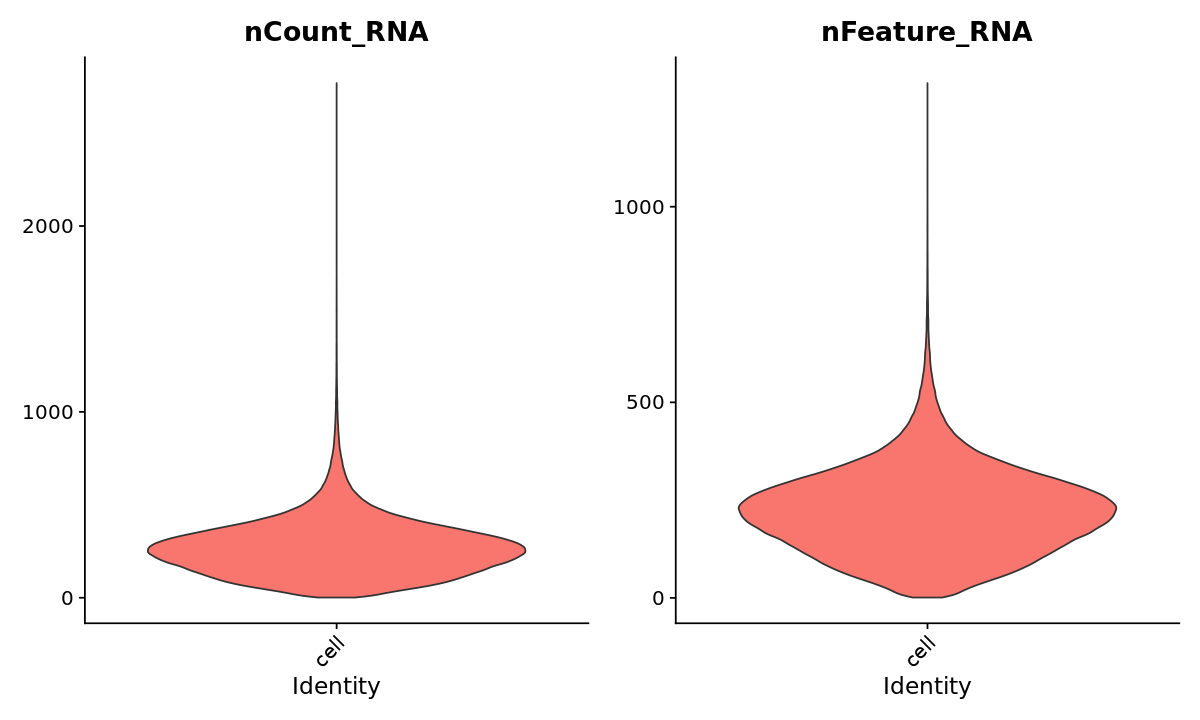

In [7]:
figsize(10, 6)
VlnPlot(s, c("nCount_RNA", "nFeature_RNA"), pt.size=0)

In [8]:
cat(paste0("Mean/median number of UMIs per cell: ", round(mean(s$nCount_RNA), 0), "/", round(median(s$nCount_RNA), 0)), "\n")
cat(paste0("Mean/median number of genes per cell: ", round(mean(s$nFeature_RNA), 0), "/", round(median(s$nFeature_RNA), 0)), "\n")

Mean/median number of UMIs per cell: 270/255 
Mean/median number of genes per cell: 222/217 


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



An object of class Seurat 
5001 features across 217111 samples within 1 assay 
Active assay: RNA (5001 features, 0 variable features)
 1 dimensional reduction calculated: spatial

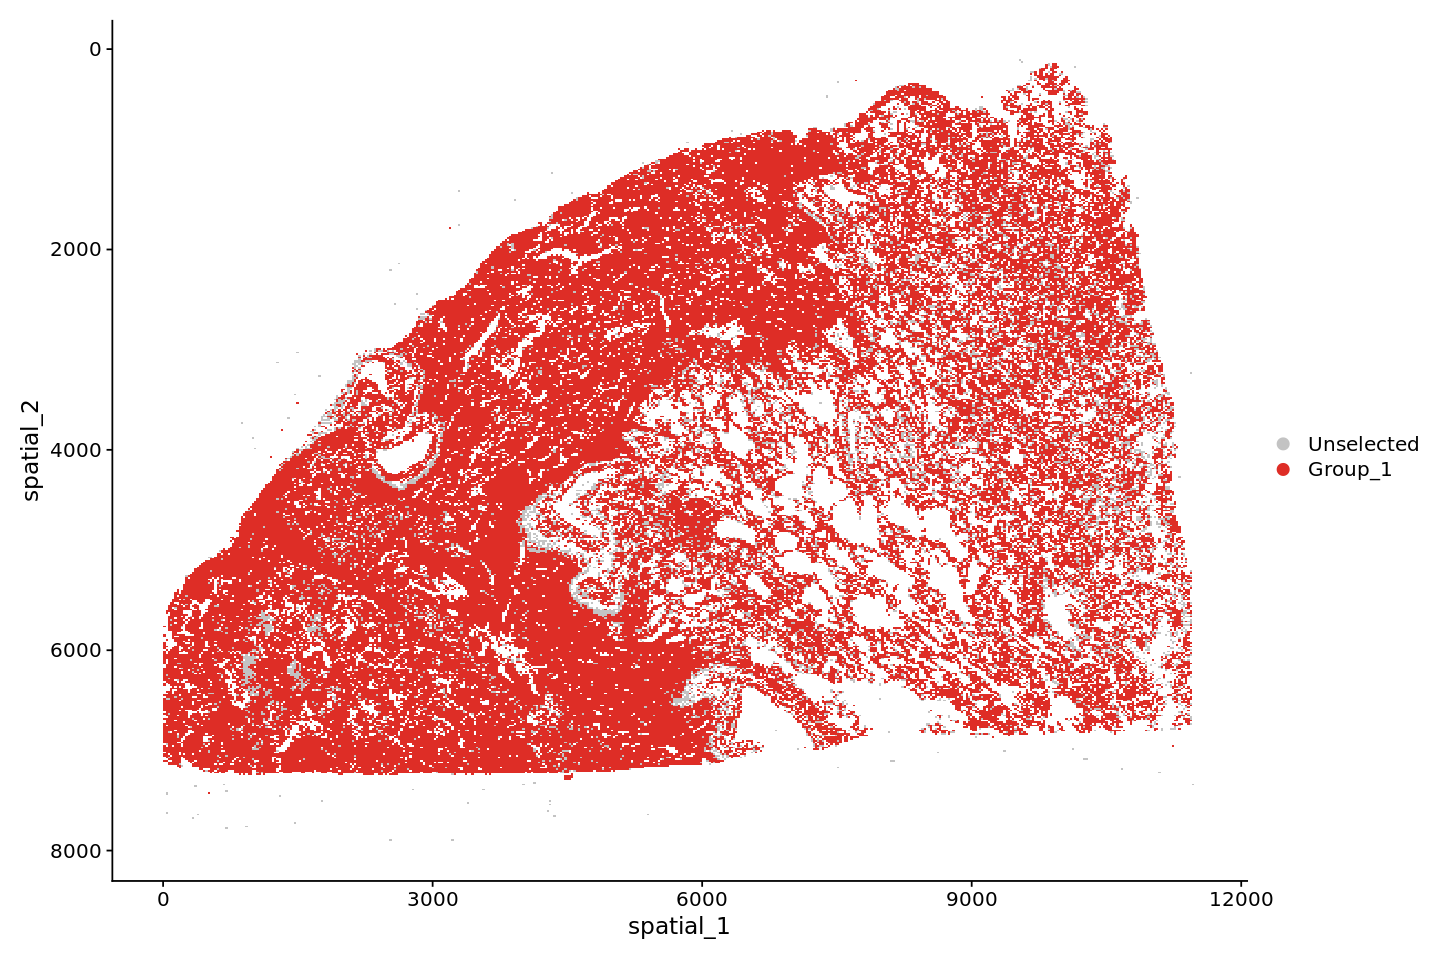

In [6]:
# Remove cells with <100 features
figsize(12, 8)
DimPlot(s, cells.highlight = colnames(s)[s$nFeature_RNA >= 100], reduction="spatial") + 
    scale_y_reverse()
s = subset(s, subset = nFeature_RNA > 100)
s

In [7]:
cat(paste0("Mean/median number of UMIs per cell: ", round(mean(s$nCount_RNA), 0), "/", round(median(s$nCount_RNA), 0)), "\n")
cat(paste0("Mean/median number of genes per cell: ", round(mean(s$nFeature_RNA), 0), "/", round(median(s$nFeature_RNA), 0)), "\n")

Mean/median number of UMIs per cell: 546/308 
Mean/median number of genes per cell: 344/243 


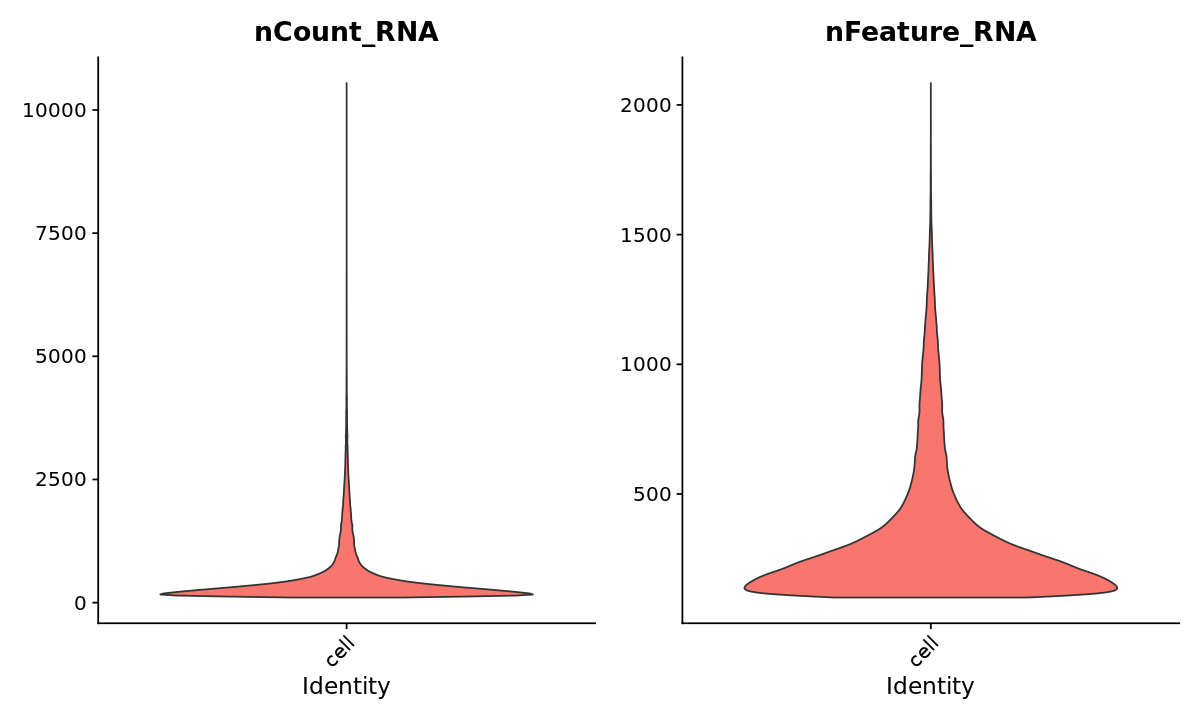

In [8]:
figsize(10, 6)
VlnPlot(s, c("nCount_RNA", "nFeature_RNA"), pt.size=0)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



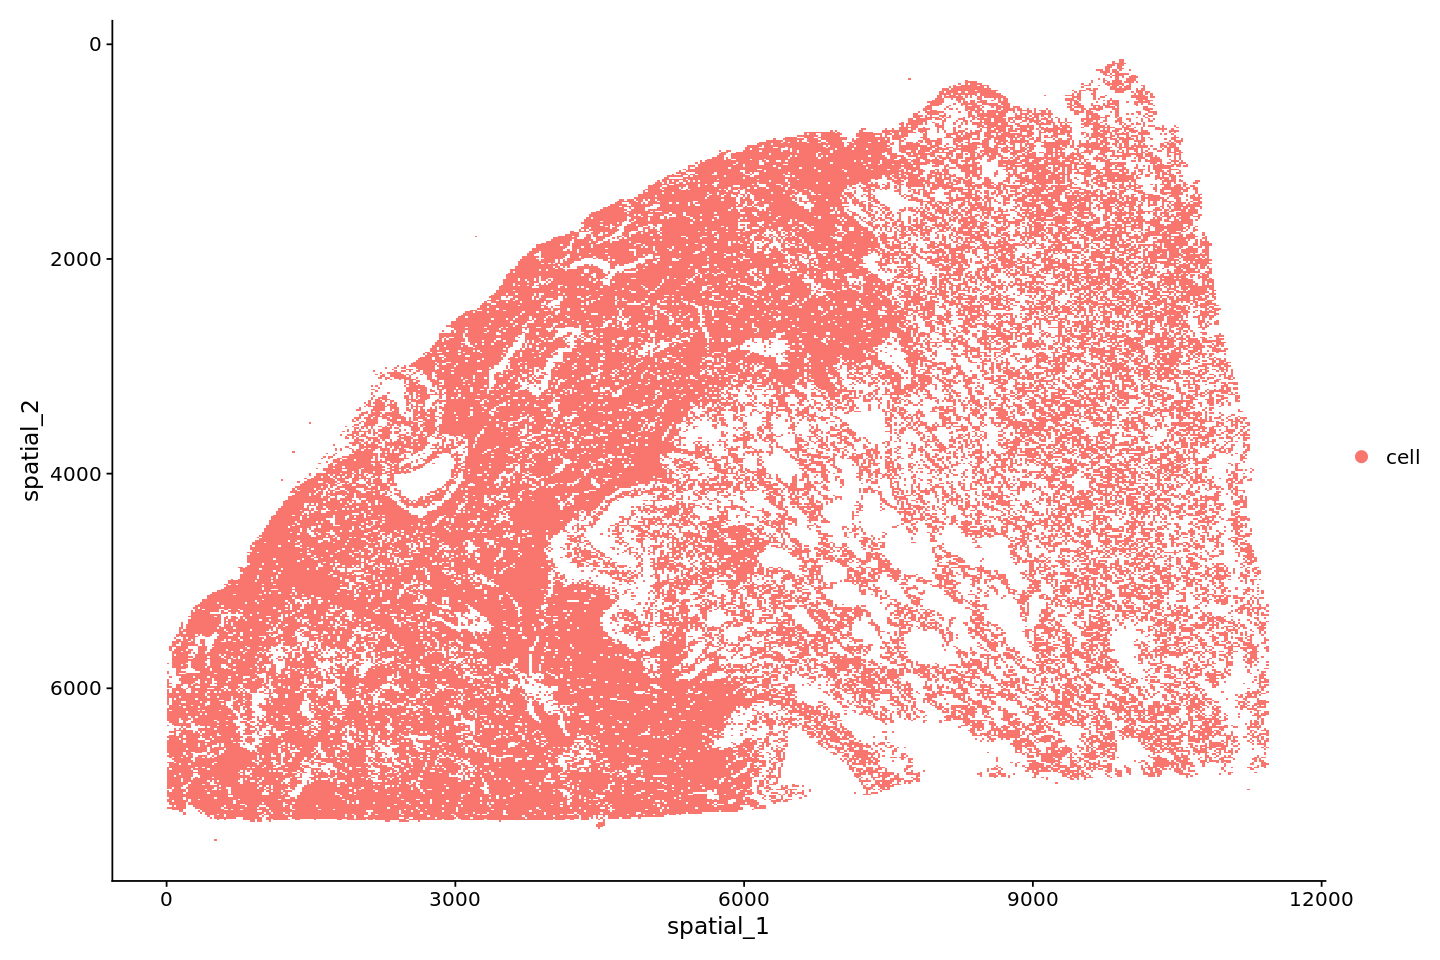

In [9]:
figsize(12, 8)
DimPlot(s, reduction="spatial") + 
    scale_y_reverse()

## Analysis with SCTransform

In [10]:
s = NormalizeData(s)

In [11]:
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
s <- CellCycleScoring(s, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

Warning message:
“The following features are not present in the object: GINS2, CDCA7, DTL, PRIM1, MLF1IP, RFC2, NASP, RAD51AP1, GMNN, WDR76, SLBP, CCNE2, UBR7, POLD3, ATAD2, CDC45, TIPIN, DSCC1, USP1, CLSPN, POLA1, CHAF1B, E2F8, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: NDC80, NUF2, CKS1B, TACC3, FAM64A, CKAP2L, TUBB4B, GTSE1, KIF20B, HJURP, HN1, NCAPD2, DLGAP5, CDCA8, ECT2, KIF23, ANLN, LBR, CENPE, G2E3, GAS2L3, not searching for symbol synonyms”


In [12]:
DietSeurat(s, dimreducs = "spatial")
s

An object of class Seurat 
5001 features across 217111 samples within 1 assay 
Active assay: RNA (5001 features, 0 variable features)
 1 dimensional reduction calculated: spatial

In [13]:
s <- Seurat::SCTransform(s, vars.to.regress = c("nCount_RNA", "S.Score", "G2M.Score"), vst.flavor="v2")
pcs = 30

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Calculating cell attributes from input UMI matrix: log_umi

Total Step 1 genes: 4593

Total overdispersed genes: 4587

Excluding 6 genes from Step 1 because they are not overdispersed.

Variance stabilizing transformation of count matrix of size 5001 by 217111

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Setting estimate of  137 genes to inf as theta_mm/theta_mle < 1e-3

# of step1 poisson genes (variance < mean): 0

# of low mean genes (mean < 0.001): 444

Total # of Step1 poisson genes (theta=Inf; variance < mean): 184

Total # of poisson genes (theta=Inf; variance < mean): 444

Calling offset model for all 444 poisson genes

Found 169 outliers - those will be ignored in fitting/regularization step


Ignoring theta inf genes

Replacing fit params for 444 poisson genes by theta=Inf

Setting min_variance based on median UMI:  0.04

Second step: Get residuals using fitted parameters for 5001 genes



  |======================================================================| 100%


Computing corrected count matrix for 5001 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 3.036953 mins

Determine variable features

Place corrected count matrix in counts slot

Regressing out nCount_RNA, S.Score, G2M.Score

Centering data matrix

Set default assay to SCT

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..SCTransform.RNA; see ?make.names for more details on syntax validity”


In [14]:
# Exclude the MT and RP from the downstream analysis
VariableFeatures(s) = grep(pattern="^RP|^MT-", VariableFeatures(s), invert = TRUE, value=TRUE)
s = RunPCA(s, npcs = pcs)
s = RunUMAP(s, dims = 1:pcs, spread=2)
s = FindNeighbors(s, dims = 1:pcs) %>% FindClusters(resolution = c(0.1, 0.15, 0.2, 0.3, 0.5, 0.8))

PC_ 1 
Positive:  CD68, CTSL, MSR1, MRC1, MARCO, CD14, MMP12, PLAUR, FCGR2A, CCL18 
	   SLCO2B1, CXCR4, ITGB2, C5AR1, LIPA, CYBB, FCGBP, GRN, ITGAX, CHIT1 
	   CTSC, SIGLEC1, MMP9, CD4, ALOX5, LGMN, SPI1, SGK1, SIRPA, FCGR2B 
Negative:  EPAS1, ADAMTS1, SOCS3, CLDN5, SERPINE1, AGER, NR4A1, FAM107A, CCN1, IL6 
	   TCIM, CAVIN2, EMP2, COL4A1, CALCRL, SHANK3, EMP1, SPTBN1, CCN2, SLC6A4 
	   VIPR1, CLDN18, LRRC32, TMEM100, LPCAT1, AOC3, CDH5, APP, CSF3, LTBP2 
PC_ 2 
Positive:  EPAS1, SOCS3, ADAMTS1, SERPINE1, THBS1, CD68, CTSL, CLDN5, MSR1, POSTN 
	   IL6, CCN1, FAM107A, MRC1, MARCO, CD14, PLAUR, EMP1, PECAM1, COL4A1 
	   LTBP2, NR4A1, SGK1, MMP12, CDKN1A, SLCO2B1, CALCRL, ENG, CAVIN2, SHANK3 
Negative:  CXCR4, MUC5B, XBP1, CD3E, LPCAT1, CLPTM1L, MZB1, ALOX15, EPCAM, PDIA4 
	   CDH1, PIM2, CD79A, TENT5C, POU2AF1, MS4A1, TPPP3, EEF1G, CD8A, DERL3 
	   LAPTM4B, NKX2-1, CD2, HHLA2, TEKT1, CTLA4, FOXJ1, PROM1, IKZF3, SLAMF7 
PC_ 3 
Positive:  LTBP2, POSTN, COL5A1, CCN1, THBS1, ADAMTS1, AEBP1, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 217111
Number of edges: 7357739

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9686
Number of communities: 11
Elapsed time: 118 seconds


1 singletons identified. 10 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 217111
Number of edges: 7357739

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9632
Number of communities: 14
Elapsed time: 140 seconds


1 singletons identified. 13 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 217111
Number of edges: 7357739

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9584
Number of communities: 14
Elapsed time: 126 seconds


1 singletons identified. 13 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 217111
Number of edges: 7357739

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9495
Number of communities: 18
Elapsed time: 134 seconds


1 singletons identified. 17 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 217111
Number of edges: 7357739

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9366
Number of communities: 23
Elapsed time: 109 seconds


1 singletons identified. 22 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 217111
Number of edges: 7357739

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9213
Number of communities: 27
Elapsed time: 112 seconds


1 singletons identified. 26 final clusters.



In [15]:
saveRDS(s, "/staging/leuven/stg_00080/vrc/Projects/Project_Sam/Xenium/objects/NSCLC/NSCLC_SCT.rds")